In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 09 - CNN with Fibonacci 

### v4 Ensemble

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Test on stage 1 data.

Original model: 'model_9_CNN_with_Fibonacci_4_Ensemble'

Ensemble: automatically evaluate the same model 4 times

In [2]:
model_name = 'model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_1.csv'

In [5]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_1.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

In [12]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [13]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

weekday(X_input_first_day), weekday(X_output_first_day)

Both are Wednesday (2).

#### Y

In [14]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [15]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

daydiff(Y_input_first_day, Y_input_final_day)

In [16]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [17]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

weekday(Y_input_first_day), weekday(Y_output_first_day)

Both are Sunday (6).

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [19]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
        '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
        ...
        '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25', '2015-10-26',
        '2015-10-27', '2015-10-28', '2015-10-29', '2015-10-30', '2015-10-31'],
       dtype='object', length=123),
 Index(['2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10',
        '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15',
        ...
        '2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23', '2016-10-24',
        '2016-10-25', '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29'],
       dtype='object', length=329))

In [20]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(2, 6)

In [21]:
fib_output_data = input_df[fib_output_dates].values; fib_output_data

array([[ 20.,  12.,  25., ...,  20.,  12.,  19.],
       [ 16.,  15.,  10., ...,  21.,  27.,  33.],
       [  3.,   1.,   5., ...,   3.,   3.,   2.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [22]:
fib_input_data = input_df[fib_input_dates].values; fib_input_data

array([[ 18.,  11.,   5., ...,   7.,   9.,  10.],
       [ 11.,  14.,  15., ...,  17.,  36.,  13.],
       [  1.,   0.,   1., ...,   1.,  10.,   5.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

#### Fibonacci median in each window

In [23]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [24]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [25]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [26]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [27]:
fib_input_median

array([ 10.,  17.,   3., ...,   0.,   0.,   0.])

In [28]:
fib_output_median

array([ 18.  ,  25.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center and part of the result

In [29]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

input_data contains X_input and Y_input array

In [30]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates, X_input_first_day, Y_input_final_day

(Index(['2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
        '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
        ...
        '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
        '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
       dtype='object', length=126), '2015-08-30', '2016-01-02')

In [31]:
input_data = input_df[input_dates].values; #input_data  # input_data with nan

##### Convert nan to number 0.

In [32]:
input_data_num = np.nan_to_num(input_data); #input_data_num  # intput_data with nan -> 0.

input_data_num.shape

### Output Data

output_data for this self-testing script contains both X_output and Y_output

In [33]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates, X_output_first_day, X_output_final_day, Y_output_final_day

(Index(['2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
        '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
        ...
        '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
        '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
       dtype='object', length=126), '2016-08-28', '2016-10-29', '2016-12-31')

In [34]:
output_dates.shape

(126,)

In [35]:
output_data = input_df[output_dates].values; #output_data

##### Convert nan to number 0.

In [36]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [37]:
output_data_num.shape

(145063, 126)

### View

def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
        
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
    
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [38]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [39]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [40]:
input_data_log.shape, input_data.shape, output_data_log.shape, output_data.shape

((145063, 126), (145063, 126), (145063, 126), (145063, 126))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [41]:
gc.collect()

283

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [42]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [43]:
input_center, output_center

(array([[ 1.2787536 ],
        [ 1.41912931],
        [ 0.69897   ],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]), array([[ 1.2787536 ],
        [ 1.41912931],
        [ 0.69897   ],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]))

#### Choice of default scale

In [44]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

In [45]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python3\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17761325467081579

In [46]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python3\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.18506594254286068

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [47]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22974401],
       [ 0.23685744],
       [ 0.27363311],
       ..., 
       [ 0.17761325],
       [ 0.17761325],
       [ 0.17761325]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [48]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.19725496],
       [ 0.25052371],
       [ 0.21878369],
       ..., 
       [ 0.18506594],
       [ 0.18506594],
       [ 0.18506594]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [49]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [50]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [51]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [52]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [53]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
#input_gp, output_gp

In [54]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
#gp_input_counts

In [55]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
#gp_output_counts

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [56]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [57]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [58]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [59]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

X_input = X_input
Y_input = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

X_input_ori = X_input_ori
Y_input_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [60]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -105.719975785 65.6597134457 -0.426355089622 4.20862520473
(145063, 63) -105.719975785 83.3110546554 -0.266078186606 4.1968139313
(145063, 63) -74.7193045163 8.00100800101 0.0 1.31777839212
(145063, 63) -74.7193045163 113.196352261 0.0 2.30496844377
(145063, 63) 0.0 21553554.0 75.0 64150.7195046
(145063, 63) 0.0 21366420.0 88.0 62373.0578871
(145063, 63) 0.0 33446984.0 139.0 87516.7023757
(145063, 63) 0.0 28342885.0 143.0 81329.6278471


#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [61]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [62]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [63]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [64]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), 1e-07, None))
    return 200. * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [65]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(106.06486177620084, 147.66867299569452, 0.0)

In [66]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(56.816030253680275, 51.874930937113326)

In [67]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

58.11634777 141.793205625


In [68]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

45.4365179097
45.8794412579


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [69]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

In [70]:
n_ens = 5
ens_list = list(range(n_ens))

In [71]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,))
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_t = Flatten()(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        model = Model(inputs=layer_0, outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 1: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 2: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 3: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 4: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 


In [72]:
models_ens[0][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 120)           720       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 120)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3480)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               417720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
__________

In [73]:
np.array(models_ens).shape

(5, 6)

In [74]:
len(gp_list)

6

In [75]:
epochs_list = [1,1,40,40,60,80]  # change to smaller epochs later (1,1,20,40,60,80)

In [76]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list):
        print('-- Group:', gp, '/', len(gp_list), '--')
        hist = model.fit(X_in, Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 0 / 5 ===
-- Group: 0 / 6 --
Train on 3079 samples, validate on 343 samples
Epoch 1/1
4s - loss: 0.2412 - k_smape: 194.0479 - val_loss: 0.0350 - val_k_smape: 199.9296
-- Group: 1 / 6 --
Train on 20794 samples, validate on 2311 samples
Epoch 1/1
4s - loss: 1.0559 - k_smape: 131.4223 - val_loss: 0.8086 - val_k_smape: 133.5345
-- Group: 2 / 6 --
Train on 36237 samples, validate on 4027 samples
Epoch 1/40
8s - loss: 1.2508 - k_smape: 118.9129 - val_loss: 0.7966 - val_k_smape: 114.6282
Epoch 2/40
7s - loss: 1.1295 - k_smape: 109.4379 - val_loss: 0.8084 - val_k_smape: 120.5745
Epoch 3/40
7s - loss: 1.1006 - k_smape: 108.0828 - val_loss: 0.7622 - val_k_smape: 118.5962
Epoch 4/40
7s - loss: 1.0976 - k_smape: 107.9590 - val_loss: 0.7742 - val_k_smape: 118.4099
Epoch 5/40
8s - loss: 1.0880 - k_smape: 107.6018 - val_loss: 0.7615 - val_k_smape: 117.8993
Epoch 6/40
7s - loss: 1.0800 - k_smape: 107.1503 - val_loss: 0.7556 - val_k_smape: 115.9357
Epoch 7/40
7s - loss: 1.0751 - k_smape: 106.7

0s - loss: 2.7343 - k_smape: 116.5662 - val_loss: 2.5866 - val_k_smape: 112.5477
Epoch 6/60
0s - loss: 2.5268 - k_smape: 111.4502 - val_loss: 2.2936 - val_k_smape: 107.5048
Epoch 7/60
0s - loss: 2.3935 - k_smape: 107.8850 - val_loss: 2.2113 - val_k_smape: 106.7611
Epoch 8/60
0s - loss: 2.2355 - k_smape: 103.5314 - val_loss: 2.3706 - val_k_smape: 106.0343
Epoch 9/60
0s - loss: 2.2487 - k_smape: 100.6453 - val_loss: 1.7346 - val_k_smape: 98.2343
Epoch 10/60
0s - loss: 2.1160 - k_smape: 97.2928 - val_loss: 2.0593 - val_k_smape: 101.6430
Epoch 11/60
0s - loss: 2.1283 - k_smape: 96.3086 - val_loss: 2.4917 - val_k_smape: 102.3139
Epoch 12/60
0s - loss: 2.0844 - k_smape: 94.8810 - val_loss: 1.4792 - val_k_smape: 94.2348
Epoch 13/60
0s - loss: 2.0746 - k_smape: 94.8613 - val_loss: 1.6217 - val_k_smape: 95.4909
Epoch 14/60
0s - loss: 2.0151 - k_smape: 92.5214 - val_loss: 1.4182 - val_k_smape: 91.9853
Epoch 15/60
0s - loss: 2.0060 - k_smape: 90.2691 - val_loss: 2.1921 - val_k_smape: 98.7084
Epoc

0s - loss: 5.1378 - k_smape: 86.8063 - val_loss: 2.1207 - val_k_smape: 86.4293
Epoch 35/80
0s - loss: 5.1349 - k_smape: 87.8799 - val_loss: 2.0757 - val_k_smape: 84.8957
Epoch 36/80
0s - loss: 5.0265 - k_smape: 86.1076 - val_loss: 2.0585 - val_k_smape: 84.0339
Epoch 37/80
0s - loss: 5.1709 - k_smape: 86.9686 - val_loss: 2.0341 - val_k_smape: 83.2357
Epoch 38/80
0s - loss: 5.0842 - k_smape: 84.9753 - val_loss: 2.0294 - val_k_smape: 82.8333
Epoch 39/80
0s - loss: 5.1271 - k_smape: 86.6115 - val_loss: 1.9889 - val_k_smape: 81.1038
Epoch 40/80
0s - loss: 4.9342 - k_smape: 85.7279 - val_loss: 1.9238 - val_k_smape: 78.9311
Epoch 41/80
0s - loss: 4.6355 - k_smape: 81.3122 - val_loss: 1.8918 - val_k_smape: 77.7823
Epoch 42/80
0s - loss: 4.7985 - k_smape: 81.1380 - val_loss: 1.8370 - val_k_smape: 76.3853
Epoch 43/80
0s - loss: 4.7339 - k_smape: 81.0829 - val_loss: 1.8013 - val_k_smape: 75.3833
Epoch 44/80
0s - loss: 4.6377 - k_smape: 79.3066 - val_loss: 1.7685 - val_k_smape: 74.3690
Epoch 45/80

7s - loss: 1.0150 - k_smape: 102.1523 - val_loss: 0.7863 - val_k_smape: 116.6812
Epoch 40/40
7s - loss: 1.0180 - k_smape: 101.9520 - val_loss: 0.7938 - val_k_smape: 117.1491
-- Group: 3 / 6 --
Train on 69674 samples, validate on 7742 samples
Epoch 1/40
15s - loss: 1.4620 - k_smape: 103.1072 - val_loss: 1.1071 - val_k_smape: 102.3363
Epoch 2/40
14s - loss: 1.2910 - k_smape: 95.0382 - val_loss: 1.0691 - val_k_smape: 100.2432
Epoch 3/40
15s - loss: 1.2627 - k_smape: 94.0220 - val_loss: 1.0945 - val_k_smape: 98.4050
Epoch 4/40
14s - loss: 1.2564 - k_smape: 93.4529 - val_loss: 1.0041 - val_k_smape: 97.0569
Epoch 5/40
14s - loss: 1.2525 - k_smape: 93.1773 - val_loss: 1.0183 - val_k_smape: 98.9749
Epoch 6/40
15s - loss: 1.2484 - k_smape: 93.0550 - val_loss: 1.0339 - val_k_smape: 99.8240
Epoch 7/40
14s - loss: 1.2389 - k_smape: 92.6262 - val_loss: 1.0711 - val_k_smape: 98.8985
Epoch 8/40
14s - loss: 1.2353 - k_smape: 92.3435 - val_loss: 1.0678 - val_k_smape: 97.8220
Epoch 9/40
14s - loss: 1.23

0s - loss: 1.5661 - k_smape: 75.7267 - val_loss: 1.1667 - val_k_smape: 88.0398
Epoch 50/60
0s - loss: 1.6148 - k_smape: 76.0448 - val_loss: 1.3416 - val_k_smape: 92.3903
Epoch 51/60
0s - loss: 1.5916 - k_smape: 75.0437 - val_loss: 1.9263 - val_k_smape: 93.4797
Epoch 52/60
0s - loss: 1.5919 - k_smape: 74.2229 - val_loss: 1.4356 - val_k_smape: 90.0946
Epoch 53/60
0s - loss: 1.5350 - k_smape: 73.9523 - val_loss: 1.1551 - val_k_smape: 91.0570
Epoch 54/60
0s - loss: 1.5710 - k_smape: 74.8271 - val_loss: 1.7310 - val_k_smape: 90.1380
Epoch 55/60
0s - loss: 1.6114 - k_smape: 73.5872 - val_loss: 1.7715 - val_k_smape: 92.1968
Epoch 56/60
0s - loss: 1.5719 - k_smape: 74.3324 - val_loss: 1.2643 - val_k_smape: 89.5850
Epoch 57/60
0s - loss: 1.5907 - k_smape: 73.4564 - val_loss: 1.4963 - val_k_smape: 89.8937
Epoch 58/60
0s - loss: 1.5347 - k_smape: 73.9863 - val_loss: 1.3099 - val_k_smape: 88.4784
Epoch 59/60
0s - loss: 1.7269 - k_smape: 76.3381 - val_loss: 1.4461 - val_k_smape: 93.2158
Epoch 60/60

Epoch 80/80
0s - loss: 3.3335 - k_smape: 66.4993 - val_loss: 1.8735 - val_k_smape: 72.1834
=== Run: 2 / 5 ===
-- Group: 0 / 6 --
Train on 3079 samples, validate on 343 samples
Epoch 1/1
1s - loss: 0.2390 - k_smape: 193.5990 - val_loss: 0.0322 - val_k_smape: 199.7093
-- Group: 1 / 6 --
Train on 20794 samples, validate on 2311 samples
Epoch 1/1
5s - loss: 1.0606 - k_smape: 132.3841 - val_loss: 0.8349 - val_k_smape: 132.9233
-- Group: 2 / 6 --
Train on 36237 samples, validate on 4027 samples
Epoch 1/40
8s - loss: 1.2411 - k_smape: 119.1403 - val_loss: 0.7943 - val_k_smape: 115.6163
Epoch 2/40
7s - loss: 1.1210 - k_smape: 109.0736 - val_loss: 0.8252 - val_k_smape: 118.0459
Epoch 3/40
7s - loss: 1.0983 - k_smape: 107.9119 - val_loss: 0.7702 - val_k_smape: 115.8751
Epoch 4/40
7s - loss: 1.0889 - k_smape: 107.3081 - val_loss: 0.8738 - val_k_smape: 119.0949
Epoch 5/40
7s - loss: 1.0822 - k_smape: 107.1352 - val_loss: 0.8041 - val_k_smape: 115.9845
Epoch 6/40
7s - loss: 1.0771 - k_smape: 107.12

0s - loss: 3.1330 - k_smape: 129.7999 - val_loss: 3.2473 - val_k_smape: 125.2200
Epoch 4/60
0s - loss: 2.8786 - k_smape: 122.0843 - val_loss: 2.8756 - val_k_smape: 118.4647
Epoch 5/60
0s - loss: 2.6598 - k_smape: 115.1552 - val_loss: 2.6772 - val_k_smape: 115.3133
Epoch 6/60
0s - loss: 2.5109 - k_smape: 110.5370 - val_loss: 2.2183 - val_k_smape: 108.7984
Epoch 7/60
0s - loss: 2.3884 - k_smape: 107.5487 - val_loss: 2.1581 - val_k_smape: 105.0245
Epoch 8/60
0s - loss: 2.2899 - k_smape: 102.1684 - val_loss: 2.6184 - val_k_smape: 108.3562
Epoch 9/60
0s - loss: 2.2499 - k_smape: 100.9391 - val_loss: 1.9320 - val_k_smape: 102.2834
Epoch 10/60
0s - loss: 2.1836 - k_smape: 99.5885 - val_loss: 1.8473 - val_k_smape: 100.6798
Epoch 11/60
0s - loss: 2.1150 - k_smape: 97.1648 - val_loss: 1.8732 - val_k_smape: 97.6181
Epoch 12/60
0s - loss: 2.1259 - k_smape: 94.6826 - val_loss: 1.8934 - val_k_smape: 99.0930
Epoch 13/60
0s - loss: 2.0020 - k_smape: 93.3867 - val_loss: 2.0982 - val_k_smape: 99.9470
Ep

0s - loss: 4.9102 - k_smape: 90.0540 - val_loss: 2.3641 - val_k_smape: 91.1899
Epoch 35/80
0s - loss: 5.1192 - k_smape: 92.2838 - val_loss: 2.2876 - val_k_smape: 88.5296
Epoch 36/80
0s - loss: 5.1563 - k_smape: 90.2783 - val_loss: 2.1898 - val_k_smape: 85.3923
Epoch 37/80
0s - loss: 4.8523 - k_smape: 85.9002 - val_loss: 2.0879 - val_k_smape: 82.4023
Epoch 38/80
0s - loss: 4.9434 - k_smape: 82.9870 - val_loss: 2.0439 - val_k_smape: 81.0496
Epoch 39/80
0s - loss: 5.0810 - k_smape: 85.8333 - val_loss: 1.9937 - val_k_smape: 79.8267
Epoch 40/80
0s - loss: 4.8324 - k_smape: 84.4468 - val_loss: 1.9866 - val_k_smape: 79.4127
Epoch 41/80
0s - loss: 4.6606 - k_smape: 82.3495 - val_loss: 1.9673 - val_k_smape: 78.8955
Epoch 42/80
0s - loss: 4.4313 - k_smape: 80.3488 - val_loss: 2.0293 - val_k_smape: 80.1697
Epoch 43/80
0s - loss: 4.4086 - k_smape: 81.2877 - val_loss: 2.0959 - val_k_smape: 81.6998
Epoch 44/80
0s - loss: 4.7398 - k_smape: 84.9263 - val_loss: 2.1074 - val_k_smape: 81.5348
Epoch 45/80

7s - loss: 1.0185 - k_smape: 102.5678 - val_loss: 0.8207 - val_k_smape: 115.9253
Epoch 40/40
7s - loss: 1.0126 - k_smape: 102.2192 - val_loss: 0.8428 - val_k_smape: 117.0329
-- Group: 3 / 6 --
Train on 69674 samples, validate on 7742 samples
Epoch 1/40
15s - loss: 1.4439 - k_smape: 102.4132 - val_loss: 1.0814 - val_k_smape: 99.8368
Epoch 2/40
14s - loss: 1.2908 - k_smape: 94.7933 - val_loss: 1.0966 - val_k_smape: 99.0328
Epoch 3/40
14s - loss: 1.2718 - k_smape: 93.9632 - val_loss: 1.0200 - val_k_smape: 99.6235
Epoch 4/40
14s - loss: 1.2540 - k_smape: 93.3957 - val_loss: 1.0454 - val_k_smape: 97.6838
Epoch 5/40
14s - loss: 1.2508 - k_smape: 93.0386 - val_loss: 1.0186 - val_k_smape: 99.6647
Epoch 6/40
14s - loss: 1.2452 - k_smape: 92.9121 - val_loss: 1.0028 - val_k_smape: 97.0517
Epoch 7/40
14s - loss: 1.2404 - k_smape: 92.6374 - val_loss: 1.0092 - val_k_smape: 96.0132
Epoch 8/40
14s - loss: 1.2336 - k_smape: 92.3567 - val_loss: 1.0845 - val_k_smape: 97.7386
Epoch 9/40
14s - loss: 1.2325

0s - loss: 1.6702 - k_smape: 76.4615 - val_loss: 1.5487 - val_k_smape: 91.4294
Epoch 50/60
0s - loss: 1.5980 - k_smape: 74.8982 - val_loss: 1.1561 - val_k_smape: 88.0522
Epoch 51/60
0s - loss: 1.6000 - k_smape: 74.6877 - val_loss: 1.3775 - val_k_smape: 90.9105
Epoch 52/60
0s - loss: 1.5773 - k_smape: 75.0787 - val_loss: 1.5227 - val_k_smape: 91.1976
Epoch 53/60
0s - loss: 1.5822 - k_smape: 74.7619 - val_loss: 1.3187 - val_k_smape: 89.8591
Epoch 54/60
0s - loss: 1.6351 - k_smape: 76.3793 - val_loss: 1.2126 - val_k_smape: 89.4449
Epoch 55/60
0s - loss: 1.5366 - k_smape: 73.7134 - val_loss: 1.3252 - val_k_smape: 89.4233
Epoch 56/60
0s - loss: 1.5513 - k_smape: 73.7932 - val_loss: 1.1931 - val_k_smape: 89.6091
Epoch 57/60
0s - loss: 1.5548 - k_smape: 74.4479 - val_loss: 1.5745 - val_k_smape: 90.7801
Epoch 58/60
0s - loss: 1.4925 - k_smape: 73.8535 - val_loss: 1.1233 - val_k_smape: 90.2825
Epoch 59/60
0s - loss: 1.4920 - k_smape: 72.9953 - val_loss: 1.2037 - val_k_smape: 91.4826
Epoch 60/60

0s - loss: 3.6638 - k_smape: 68.9993 - val_loss: 1.7221 - val_k_smape: 67.4812
Epoch 80/80
0s - loss: 3.5534 - k_smape: 66.6250 - val_loss: 1.6069 - val_k_smape: 64.3955
=== Run: 4 / 5 ===
-- Group: 0 / 6 --
Train on 3079 samples, validate on 343 samples
Epoch 1/1
1s - loss: 0.2422 - k_smape: 194.1427 - val_loss: 0.0358 - val_k_smape: 199.9998
-- Group: 1 / 6 --
Train on 20794 samples, validate on 2311 samples
Epoch 1/1
5s - loss: 1.0603 - k_smape: 132.5697 - val_loss: 0.8073 - val_k_smape: 131.8729
-- Group: 2 / 6 --
Train on 36237 samples, validate on 4027 samples
Epoch 1/40
8s - loss: 1.2421 - k_smape: 119.1996 - val_loss: 0.8311 - val_k_smape: 117.8109
Epoch 2/40
7s - loss: 1.1298 - k_smape: 109.2744 - val_loss: 0.8415 - val_k_smape: 120.2249
Epoch 3/40
7s - loss: 1.1094 - k_smape: 108.1915 - val_loss: 0.8284 - val_k_smape: 119.1140
Epoch 4/40
7s - loss: 1.0917 - k_smape: 107.5048 - val_loss: 0.7857 - val_k_smape: 118.2055
Epoch 5/40
7s - loss: 1.0867 - k_smape: 107.0136 - val_loss

0s - loss: 3.1660 - k_smape: 128.0039 - val_loss: 3.1919 - val_k_smape: 123.6850
Epoch 4/60
0s - loss: 2.8671 - k_smape: 122.4196 - val_loss: 2.9492 - val_k_smape: 120.3306
Epoch 5/60
0s - loss: 2.6725 - k_smape: 116.6894 - val_loss: 2.7028 - val_k_smape: 114.4066
Epoch 6/60
0s - loss: 2.5272 - k_smape: 111.3066 - val_loss: 2.3610 - val_k_smape: 108.8096
Epoch 7/60
0s - loss: 2.3854 - k_smape: 107.0899 - val_loss: 2.6080 - val_k_smape: 109.4847
Epoch 8/60
0s - loss: 2.3338 - k_smape: 104.1071 - val_loss: 2.3492 - val_k_smape: 104.0993
Epoch 9/60
0s - loss: 2.1920 - k_smape: 100.8764 - val_loss: 2.5101 - val_k_smape: 105.9058
Epoch 10/60
0s - loss: 2.1604 - k_smape: 98.7127 - val_loss: 1.6060 - val_k_smape: 94.5467
Epoch 11/60
0s - loss: 2.2188 - k_smape: 96.9043 - val_loss: 1.7871 - val_k_smape: 96.0099
Epoch 12/60
0s - loss: 2.0391 - k_smape: 92.7763 - val_loss: 2.1368 - val_k_smape: 98.4523
Epoch 13/60
0s - loss: 2.0511 - k_smape: 93.6018 - val_loss: 1.3447 - val_k_smape: 90.8773
Epo

0s - loss: 5.2290 - k_smape: 91.4828 - val_loss: 2.2811 - val_k_smape: 93.0485
Epoch 35/80
0s - loss: 5.1605 - k_smape: 92.5243 - val_loss: 2.2671 - val_k_smape: 92.4864
Epoch 36/80
0s - loss: 5.4172 - k_smape: 91.9639 - val_loss: 2.2559 - val_k_smape: 91.8542
Epoch 37/80
0s - loss: 5.0206 - k_smape: 89.5927 - val_loss: 2.2572 - val_k_smape: 91.5124
Epoch 38/80
0s - loss: 5.0009 - k_smape: 90.3377 - val_loss: 2.2230 - val_k_smape: 89.9982
Epoch 39/80
0s - loss: 4.8700 - k_smape: 89.2627 - val_loss: 2.1919 - val_k_smape: 88.5343
Epoch 40/80
0s - loss: 5.0347 - k_smape: 86.7154 - val_loss: 2.1350 - val_k_smape: 86.6829
Epoch 41/80
0s - loss: 4.7790 - k_smape: 82.6079 - val_loss: 2.0773 - val_k_smape: 85.2974
Epoch 42/80
0s - loss: 4.9735 - k_smape: 87.4186 - val_loss: 1.9773 - val_k_smape: 83.0082
Epoch 43/80
0s - loss: 4.5287 - k_smape: 83.6099 - val_loss: 1.9279 - val_k_smape: 82.0543
Epoch 44/80
0s - loss: 4.9180 - k_smape: 85.4003 - val_loss: 1.8763 - val_k_smape: 80.9019
Epoch 45/80

### Training History

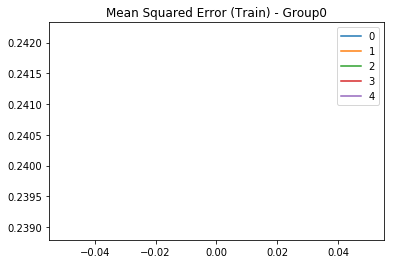

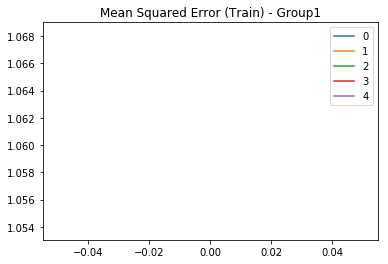

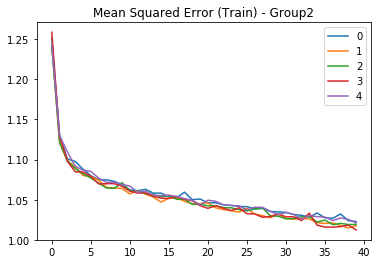

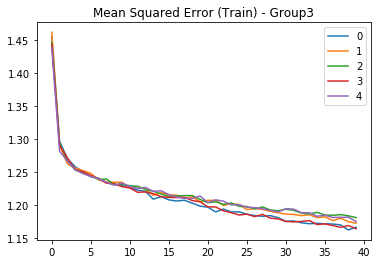

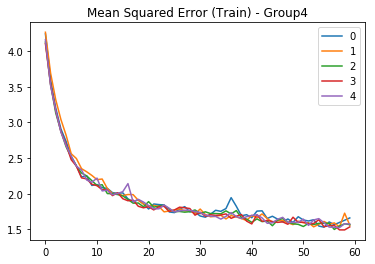

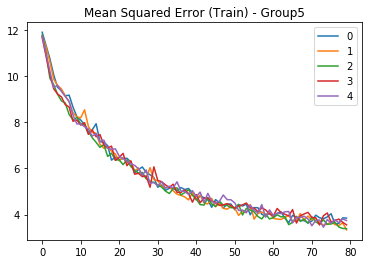

In [77]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

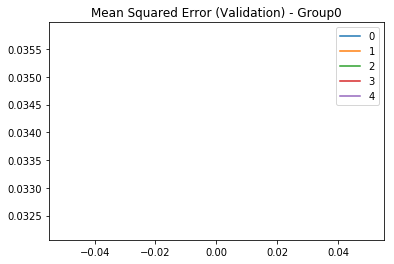

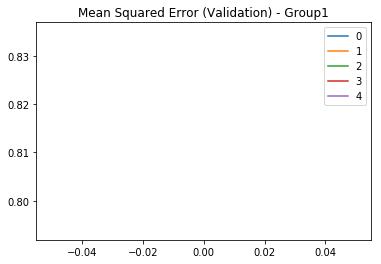

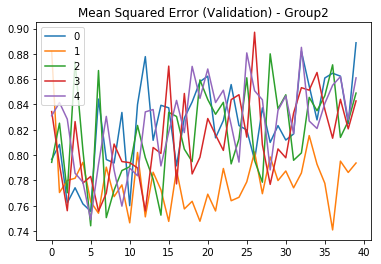

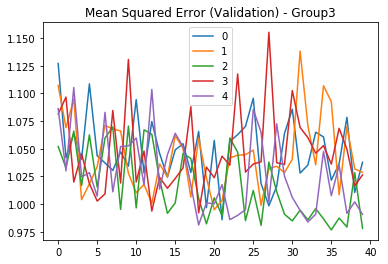

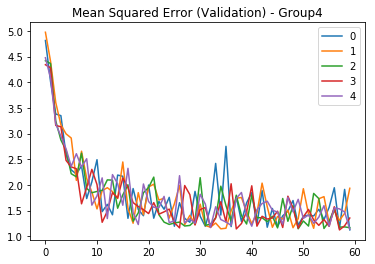

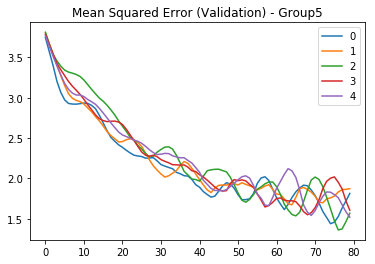

In [78]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

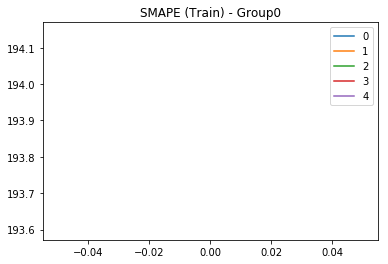

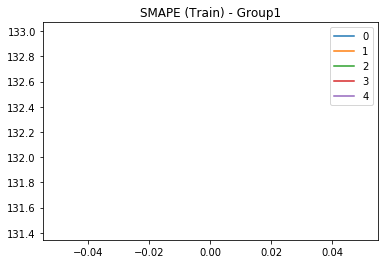

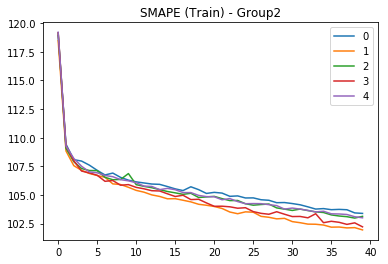

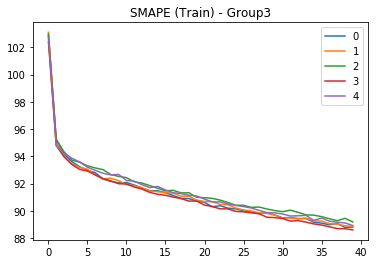

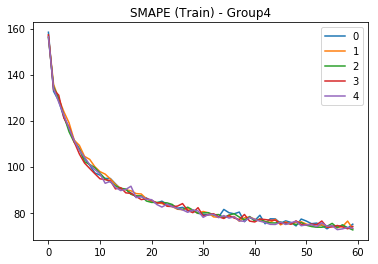

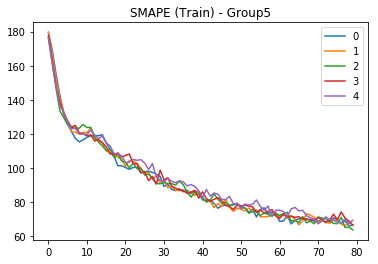

In [79]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

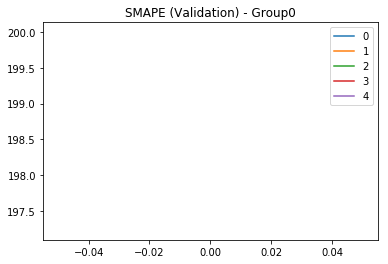

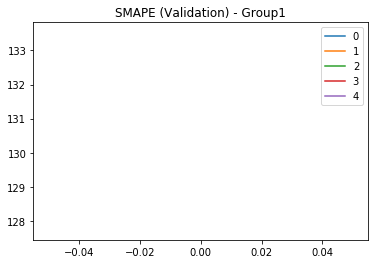

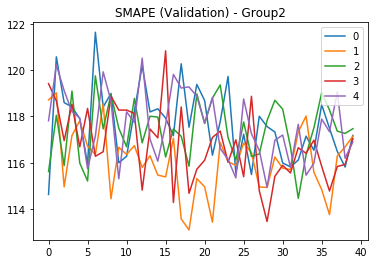

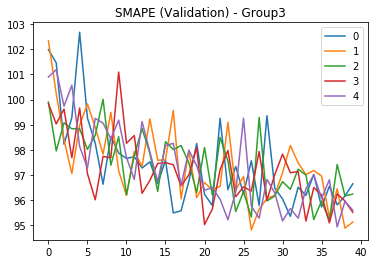

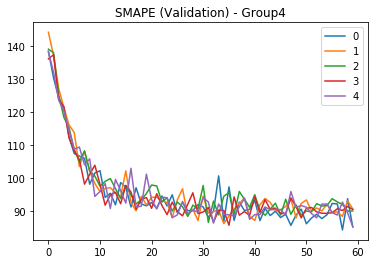

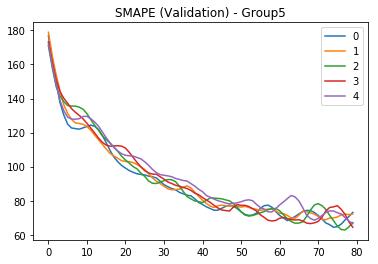

In [80]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

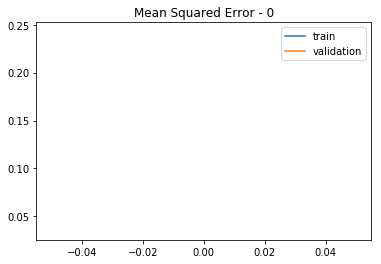

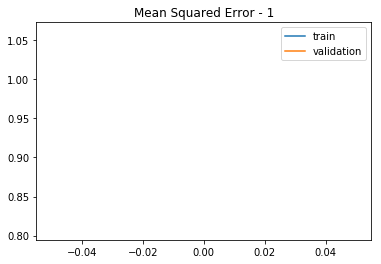

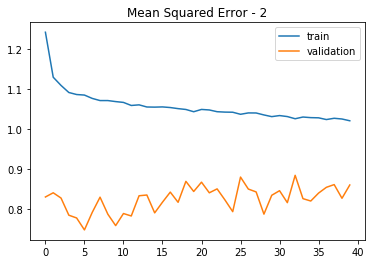

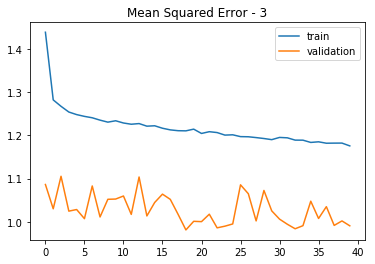

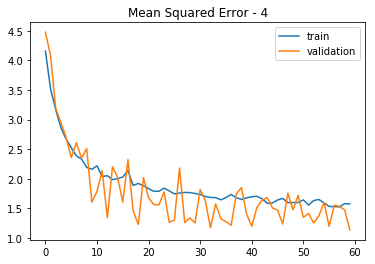

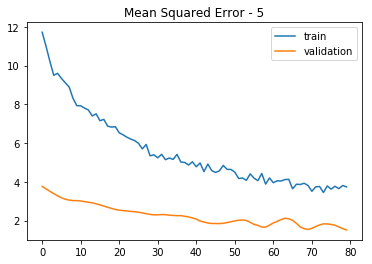

In [81]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

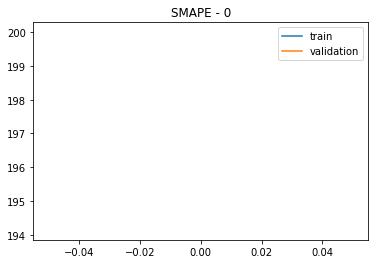

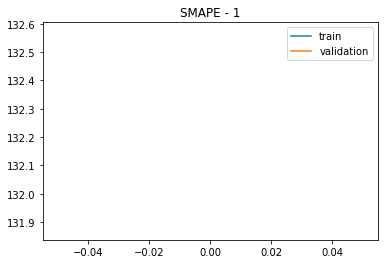

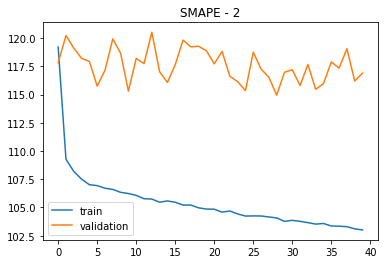

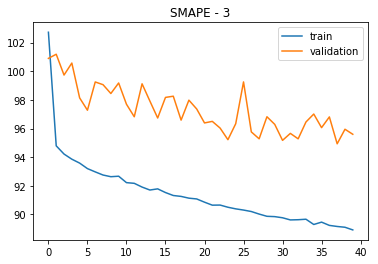

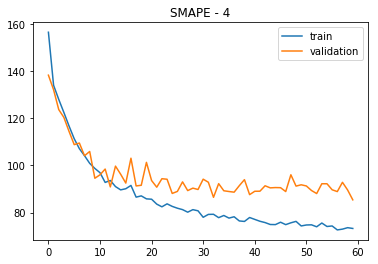

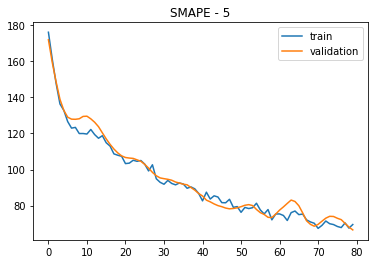

In [82]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

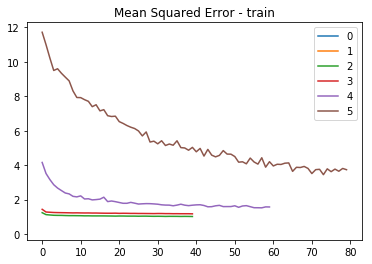

In [83]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

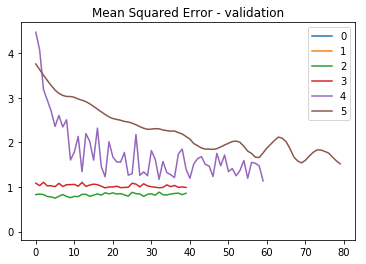

In [84]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

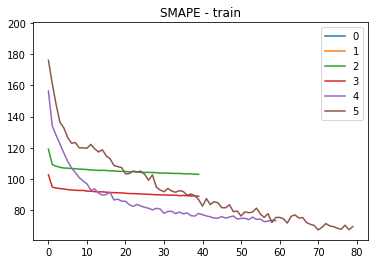

In [85]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

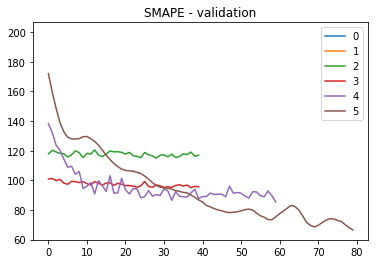

In [86]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using Output Set

if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [87]:
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X) in zip(gp_list, models, X_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict(X))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 4 5 
Run 1: 0 1 2 3 4 5 
Run 2: 0 1 2 3 4 5 
Run 3: 0 1 2 3 4 5 
Run 4: 0 1 2 3 4 5 


Find the original index

In [88]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [89]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [90]:
for o in output_index_list:
    print(o.shape)

(3422,)
(23105,)
(40264,)
(77416,)
(790,)
(66,)


In [91]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([    52,     81,    117, ..., 131296, 139119, 140151])

In [92]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred_temp = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred_temp[index] = y

    Y_output_pred = np.array(Y_output_pred_temp)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_temp

In [93]:
# Inverse transform Y of output

Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          output_center, output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

### Model Score

In [94]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape, model_smape_0)
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    print('-----------')
    print(model_smape_ens_mean, model_smape_0_ens_mean)

43.728041093 46.6308108214
43.9448326578 47.2848795195
43.7078984929 46.5965210532
43.9539323596 47.1392863786
44.0109750478 47.264124874
-----------
43.8691359302 46.9831245293


In [95]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

45.8794412579


### Group Scores
For self-testing stage only

In [96]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [97]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [98]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [99]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [100]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Individual Page Scores

In [101]:
if test_length:
    smape_Y_pred_ens = []
    #smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
    #                            in zip(Y_output_pred_ori, Y_output_raw)])
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


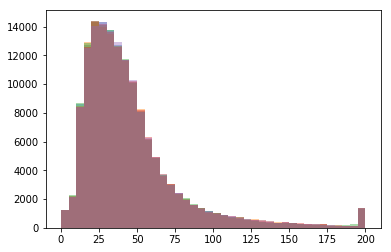

In [102]:
if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.show()

### SMAPE for the Model

In [103]:
if test_length:
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

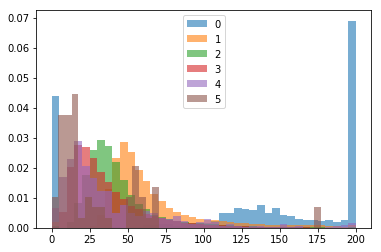

In [104]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

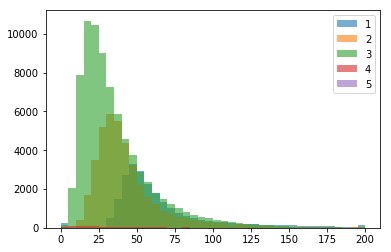

In [105]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

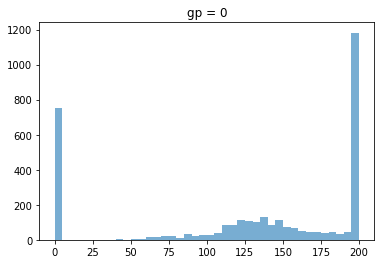

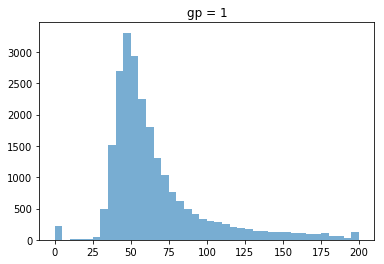

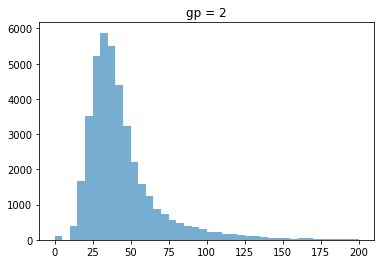

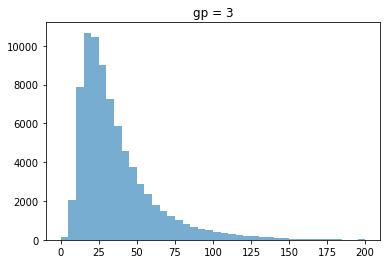

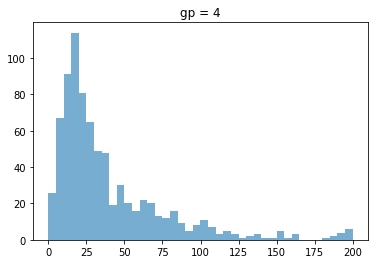

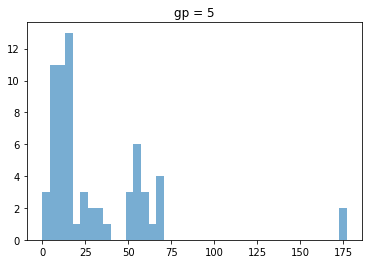

In [106]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### SMAPE for Fibonacci median

In [107]:
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [108]:
# Group SMAPE for Fib.
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [109]:
# Individual SMAPE for Fib.
if test_length:
    #smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
    #                           in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]
# The above two cells can be combined.

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


#### SMAPE distribution for Fib

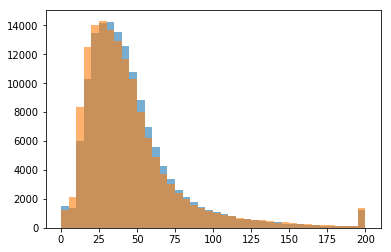

In [110]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

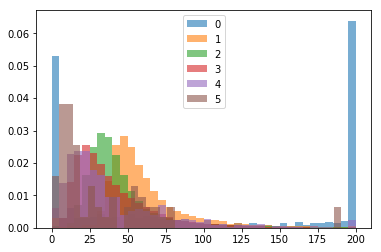

In [111]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

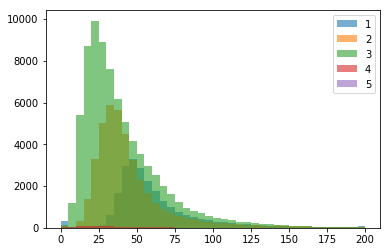

In [112]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

if test_length:
    for i in range(len(smape_Y_fib_list)):
        plt.hist(smape_Y_pred_list[i], bins=40, alpha=0.7, label='Model')
        plt.hist(smape_Y_fib_list[i], bins=40, alpha=0.5, label='Fib')
        plt.title('gp = '+str(i))
        plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### Models vs Fibonacci Median

In [113]:
if test_length:
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')

#### model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   3422 | 115.887 | 161.663 | 167.935 | 169.176 | 165.810 | 161.697 |
|  23105 |  61.823 |  63.692 |  63.570 |  63.142 |  63.726 |  63.470 |
|  40264 |  45.496 |  43.943 |  44.451 |  44.000 |  44.084 |  44.173 |
|  77416 |  40.368 |  35.828 |  35.861 |  35.761 |  36.069 |  36.282 |
|    790 |  40.033 |  39.708 |  40.381 |  39.894 |  40.225 |  39.942 |
|     66 |  33.144 |  31.300 |  31.869 |  31.800 |  31.777 |  31.985 |


#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [114]:
Y_output_fib.shape

(145063, 1)

In [115]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [116]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [117]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

In [118]:
Y_output_fmc_ori

array([[ 15.40462557,  15.64480228,  16.18168766, ...,  16.07801558,
         16.53536455,  17.76895701],
       [ 26.13334291,  26.85573619,  27.80851104, ...,  26.74719678,
         27.85091589,  30.88369322],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [119]:
model_smape_ens

[43.72804109295037,
 43.944832657750958,
 43.707898492876545,
 43.953932359556454,
 44.010975047791355]

In [120]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [121]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

42.947 (43.728) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 0
43.113 (43.945) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 1
42.927 (43.708) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 2
43.122 (43.954) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 3
43.263 (44.011) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 4
43.074 (43.869) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 Average


#### Combined Scores:
38.777 (39.377) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 2

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.174 (44.159) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 3

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

43.038 (43.990) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 1

43.479 (44.659) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 3

43.804 (45.033) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.948 (46.090) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4

43.762 (44.885) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3

43.805 (44.996) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Ensemble Learning

In [123]:
Y_output_pred_ori_ens

[array([[  1.50890486e+01,   1.56289287e+01,   1.61264476e+01, ...,
           1.55574729e+01,   1.59197919e+01,   1.72795009e+01],
        [  2.76373113e+01,   2.79211090e+01,   2.82399363e+01, ...,
           2.63333972e+01,   2.85894324e+01,   3.21304987e+01],
        [  3.76960011e+00,   3.72556844e+00,   3.90703065e+00, ...,
           3.97371735e+00,   3.64885098e+00,   4.15552438e+00],
        ..., 
        [  0.00000000e+00,   5.21097865e-05,   1.66716856e-04, ...,
           0.00000000e+00,   0.00000000e+00,   2.78539782e-06],
        [  0.00000000e+00,   5.21097865e-05,   1.66716856e-04, ...,
           0.00000000e+00,   0.00000000e+00,   2.78539782e-06],
        [  0.00000000e+00,   5.21097865e-05,   1.66716856e-04, ...,
           0.00000000e+00,   0.00000000e+00,   2.78539782e-06]]),
 array([[  1.60601188e+01,   1.57993001e+01,   1.60844933e+01, ...,
           1.59050304e+01,   1.68291584e+01,   1.80268680e+01],
        [  2.90447283e+01,   2.86308629e+01,   2.86036368e+0

### Method 1 - Mean

In [124]:
Y_output_pred_ori_ens_mean = np.mean(Y_output_pred_ori_ens, axis=0)

In [125]:
Y_output_pred_ori_ens_mean.shape

(145063, 63)

Y_output_pred_ori_ens_mean

In [126]:
smape(Y_output_pred_ori_ens_mean, Y_output_raw)

43.888049842244406

### Method 2 - Median

In [127]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)

In [128]:
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [129]:
smape(Y_output_pred_ori_ens_med, Y_output_raw)

43.595867139991888

### Method 3 - Mean before inverse transform and log

In [130]:
Y_output_pred_ens_mean = np.mean(Y_output_pred_ens, axis=0)
Y_output_pred_ens_mean_ori = unlog(untransform(Y_output_pred_ens_mean, output_center, output_scale))

In [131]:
smape(Y_output_pred_ens_mean_ori, Y_output_raw)

43.591020135059047

### Method 4 - Median before inverse transform and log

In [132]:
Y_output_pred_ens_med = np.median(Y_output_pred_ens, axis=0)
Y_output_pred_ens_med_ori = unlog(untransform(Y_output_pred_ens_med, output_center, output_scale))

In [133]:
smape(Y_output_pred_ens_med_ori, Y_output_raw)

43.595867139991888

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [134]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [135]:
# The combined result

Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
Y_output_pred_ens_med_ori

array([[  1.54046256e+01,   1.56448023e+01,   1.61264476e+01, ...,
          1.58051861e+01,   1.64478703e+01,   1.77689570e+01],
       [  2.61333429e+01,   2.71198343e+01,   2.79122145e+01, ...,
          2.67471968e+01,   2.84199325e+01,   3.12456751e+01],
       [  3.78913300e+00,   3.87964900e+00,   3.90703065e+00, ...,
          3.97371735e+00,   3.81879137e+00,   4.13376318e+00],
       ..., 
       [  3.84719568e-05,   5.80622767e-05,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.84719568e-05,   5.80622767e-05,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.84719568e-05,   5.80622767e-05,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [136]:
Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med
Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

In [191]:
if test_length:
    f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [199]:
if test_length: # The_score
    print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f         ' % f_omed_smape, '-', model_name, 'ori_ens_med')
    print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

42.730          - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 ori_ens_mean
42.718          - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 ori_ens_med
42.691          - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 ens_mean_ori
42.718          - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 ens_med_ori
43.074 (43.869) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 Average


In [121]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

42.947 (43.728) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 0
43.113 (43.945) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 1
42.927 (43.708) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 2
43.122 (43.954) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 3
43.263 (44.011) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 4
43.074 (43.869) - model_9_CNN_with_Fibonacci_4_Ensemble_2_stage_1 Average


Ensemble of model are all better than the individual model.

In [138]:
fmc_smape_ens

[42.946556247275801,
 43.11324354566117,
 42.927273248077199,
 43.122026320511573,
 43.262595917806443]

In [139]:
fmc_smape_ens_mean

43.074339055866439

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

### Plots

In [140]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

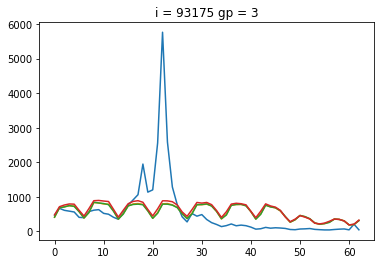

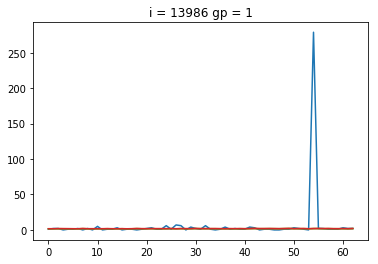

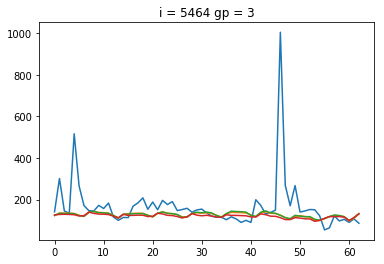

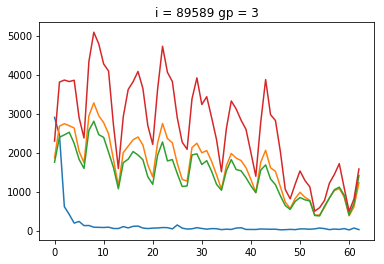

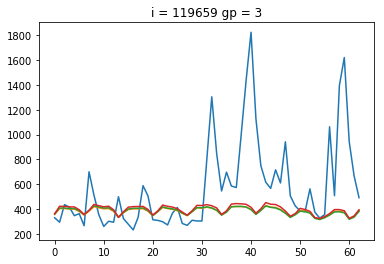

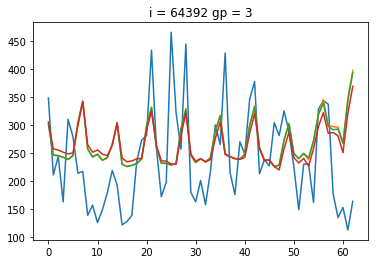

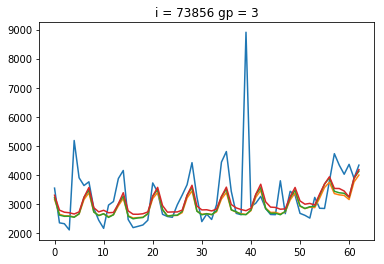

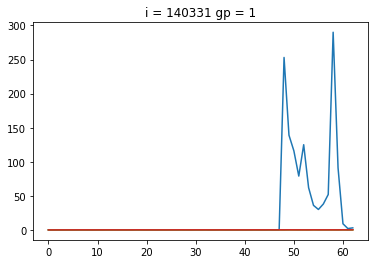

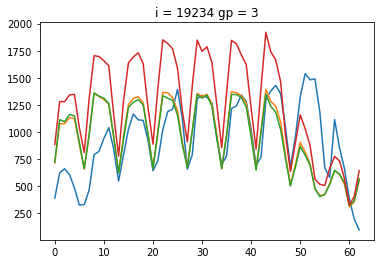

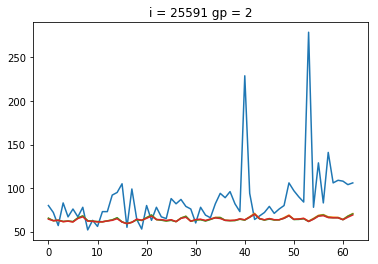

In [141]:
view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

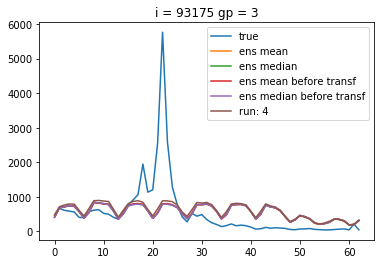

In [142]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

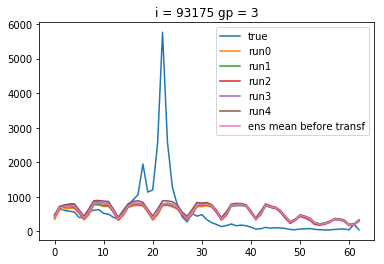

In [143]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

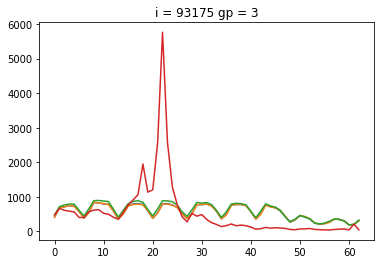

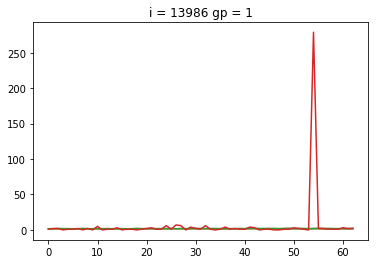

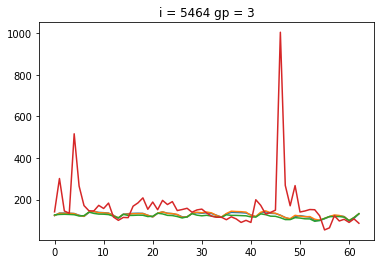

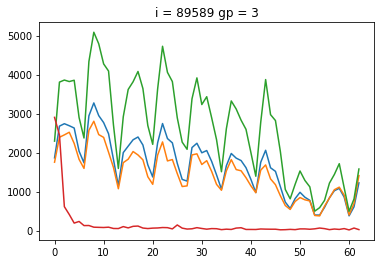

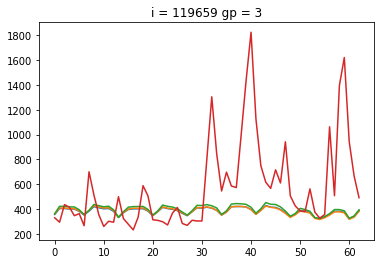

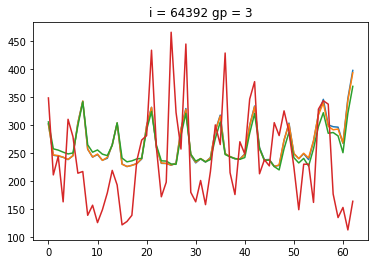

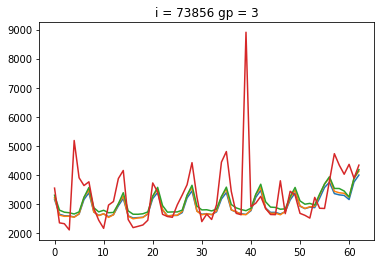

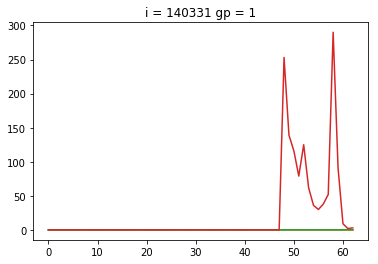

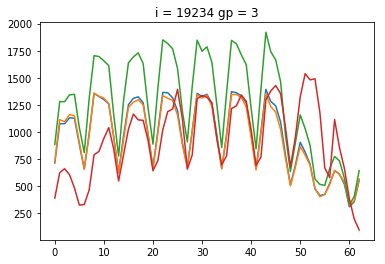

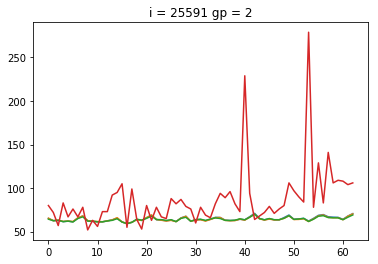

In [144]:
view_list = examine_list_gp((Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             Y_output_ori), output_gp, view_list=view_list)

## Case Study

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [145]:
view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

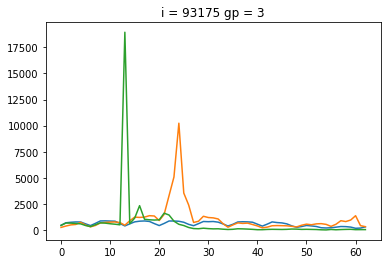

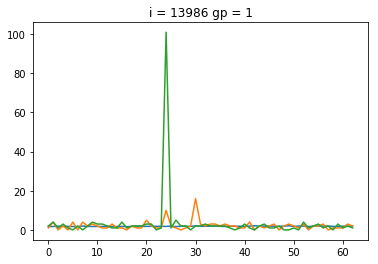

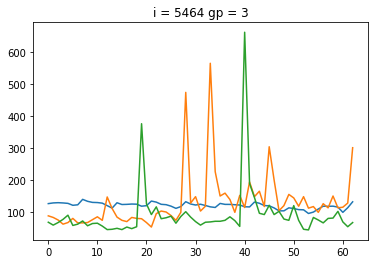

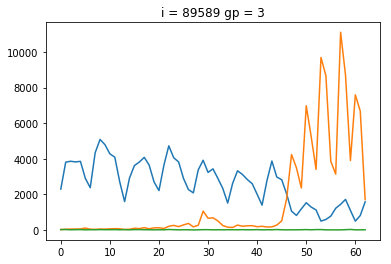

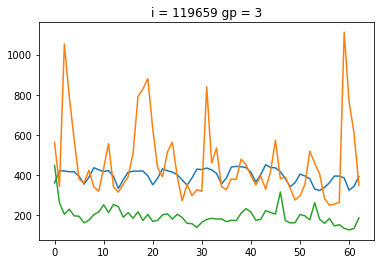

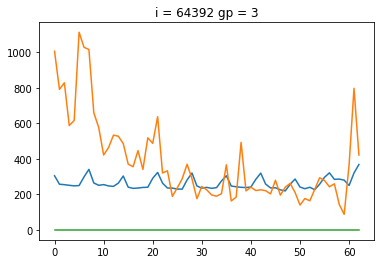

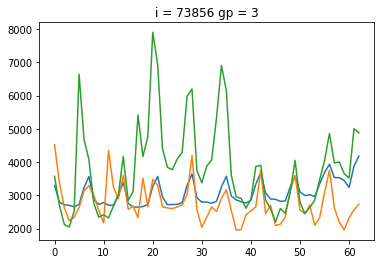

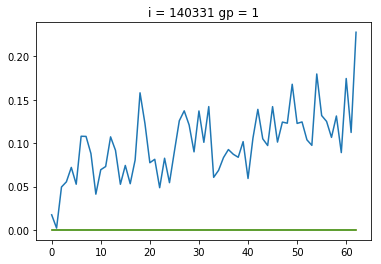

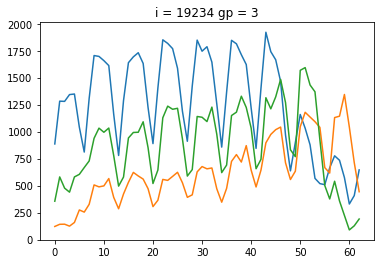

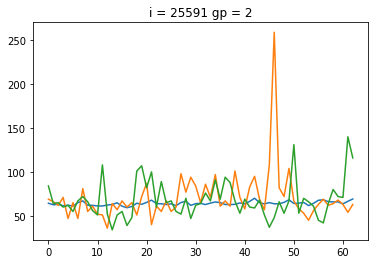

In [146]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

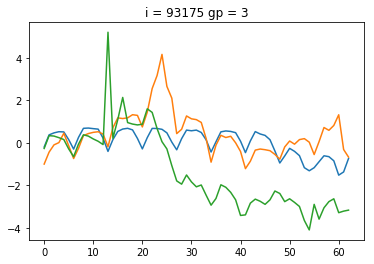

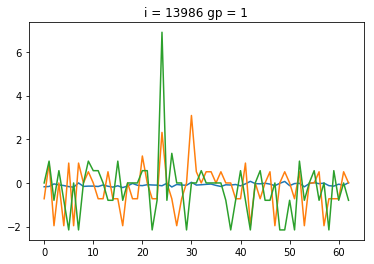

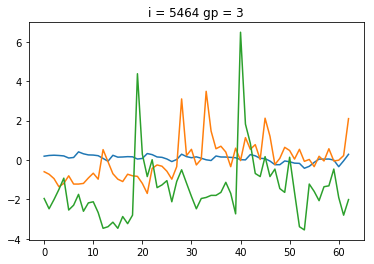

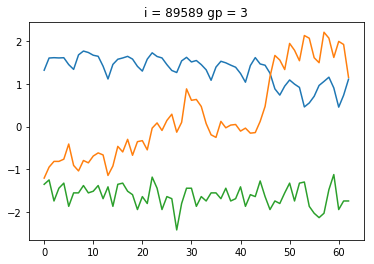

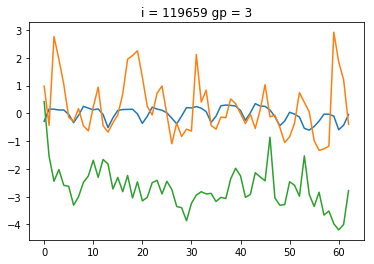

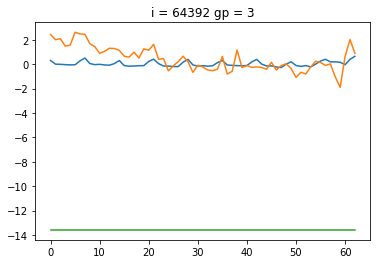

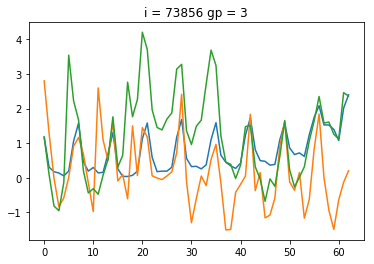

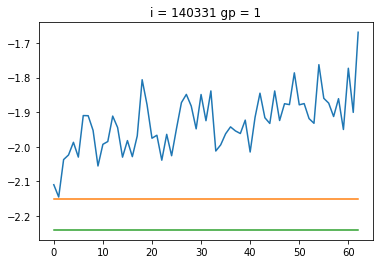

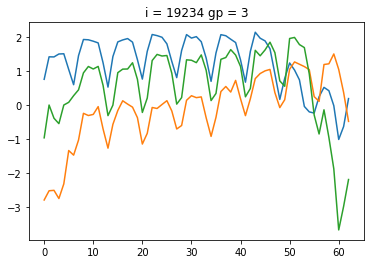

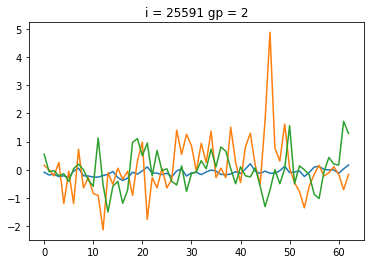

In [147]:
view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

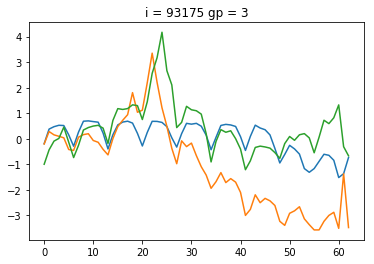

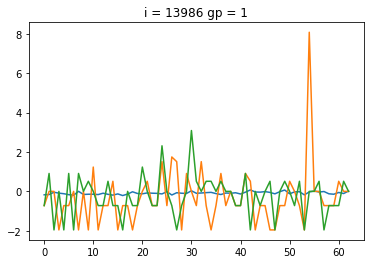

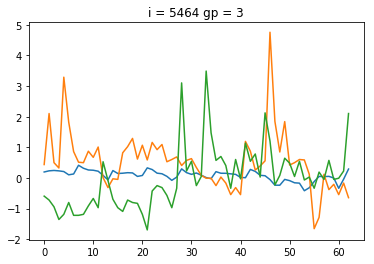

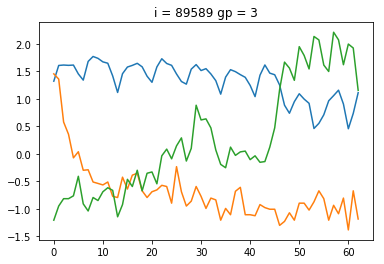

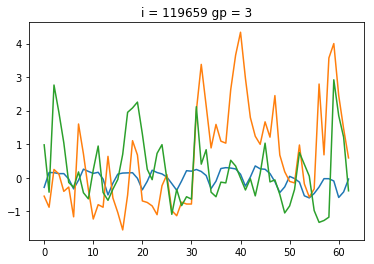

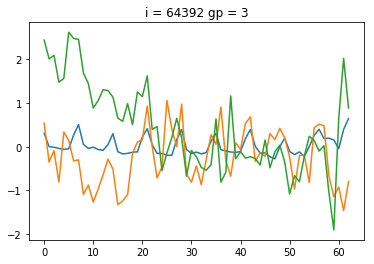

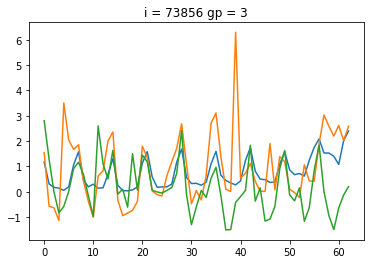

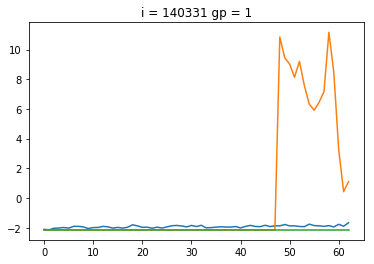

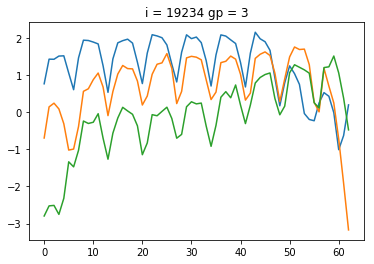

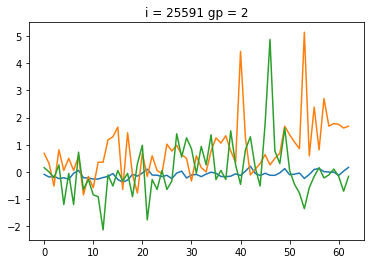

In [148]:
if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

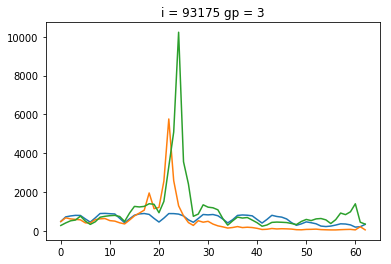

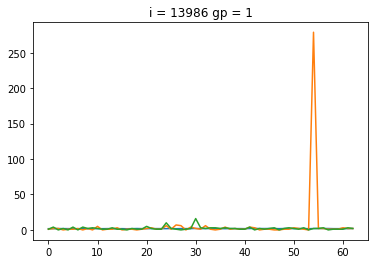

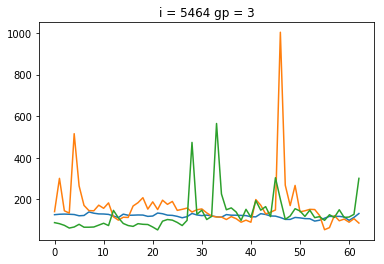

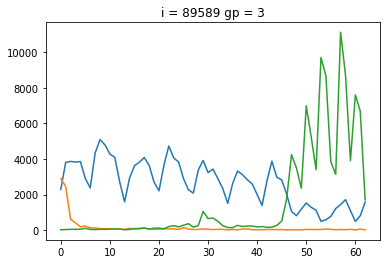

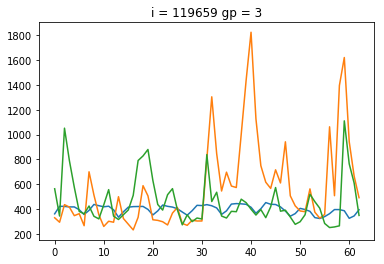

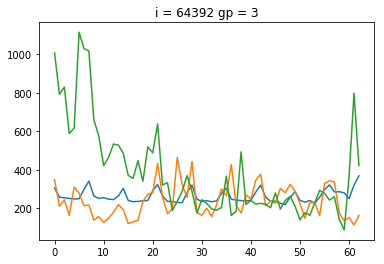

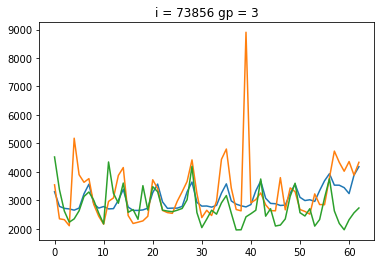

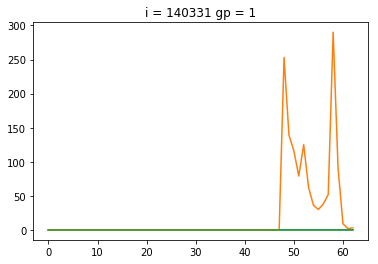

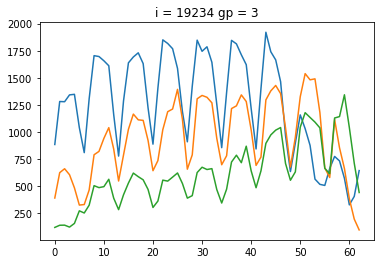

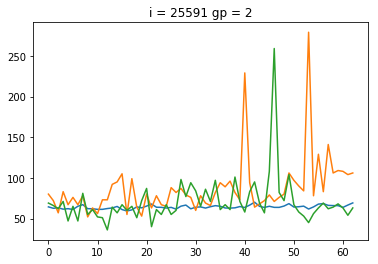

In [149]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

In [150]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[84.398487992957868,
 82.002733777175678,
 30.268659965133367,
 183.01277342283433,
 40.647874243540208,
 28.655792617184979,
 15.778631144449246,
 195.58438201132068,
 42.940578562573016,
 26.917021270432635]

In [151]:
view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

[False, False, True, False, True, True, True, False, True, True]

In [152]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[5464, 119659, 64392, 73856, 19234, 25591]

In [153]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[93175, 13986, 89589, 140331]

#### Good cases

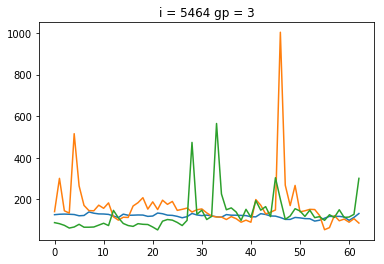

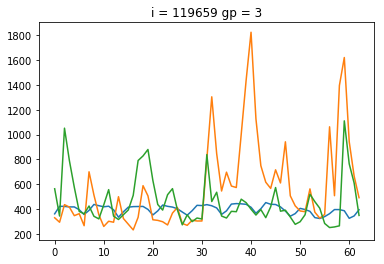

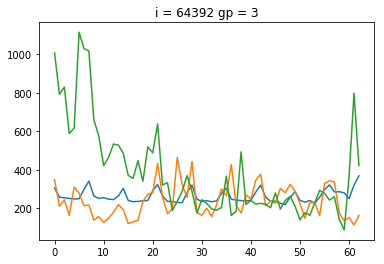

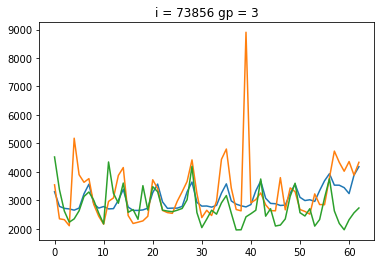

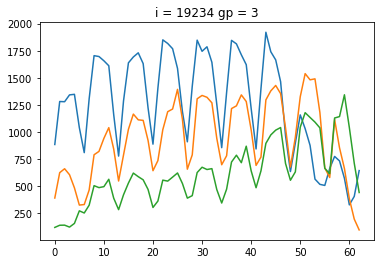

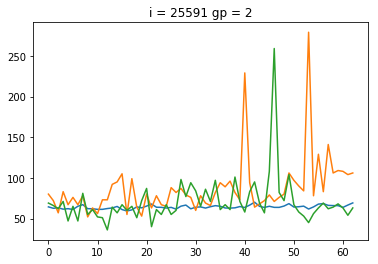

[5464, 119659, 64392, 73856, 19234, 25591]

In [154]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

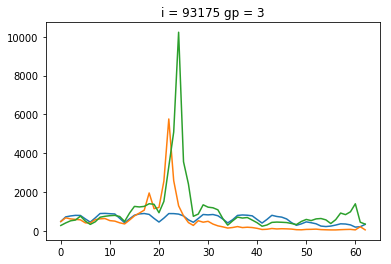

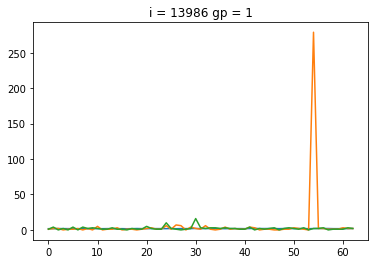

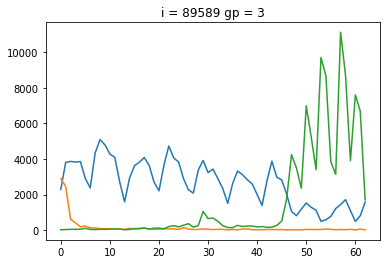

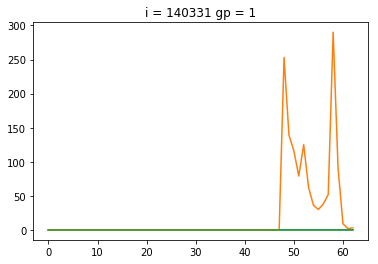

[93175, 13986, 89589, 140331]

In [155]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

In [156]:
print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

[ 2.06632593  2.60233134  2.41161971  3.41970798  2.76380222  1.8260748 ]
[ 2.73957234  0.47712125  2.34439227  0.39794001]


In [157]:
print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

[ 0.19672942  0.15196451  0.24306295  0.08421018  0.2422891   0.12070051]
[ 0.3047582   0.24391733  0.77069779  0.18506594]


In [158]:
output_gp[view_list_good]

array([3, 3, 3, 3, 3, 2])

In [159]:
output_gp[view_list_bad]

array([3, 1, 3, 1])

In [160]:
gp_smape

[161.69681961658108,
 63.469725431609604,
 44.17343495735971,
 36.282169874616635,
 39.941808113634799,
 31.98548996099559]

In [161]:
gp_n

[3422, 23105, 40264, 77416, 790, 66]

#### Case 93175

In [162]:
i = 93175

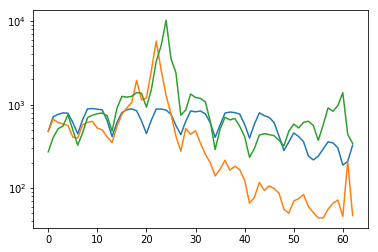

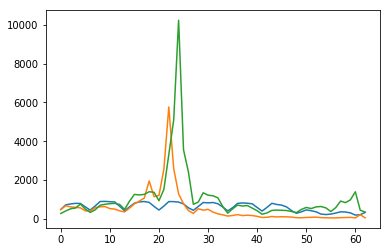

In [163]:
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

In [164]:
smape(Y_output_pred_ori[i], Y_output_raw[i])

84.398487992957868

In [165]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.73957234]),
 array([ 2.73957234]),
 array([ 0.29502917]),
 array([ 0.3047582]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

In [166]:
review_Y = np.array([score < model_smape for score in smape_Y_pred])

In [167]:
np.arange(len(Y_output_pred))

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [168]:
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; good_Y_index

array([     0,      3,      5, ..., 145060, 145061, 145062])

In [169]:
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; bad_Y_index

array([     1,      2,      4, ..., 145056, 145057, 145058])

In [170]:
good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

In [171]:
good_input_center = input_center[good_Y_index]
good_output_center = output_center[good_Y_index]
bad_input_center = input_center[bad_Y_index]
bad_output_center = output_center[bad_Y_index]

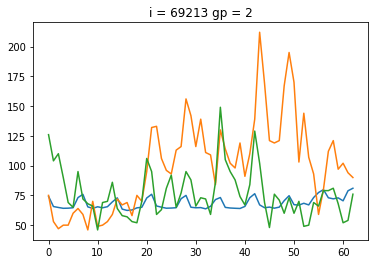

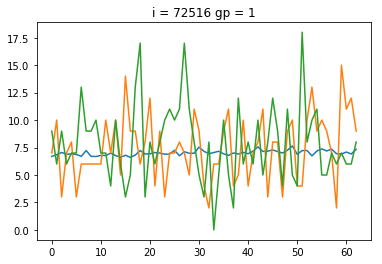

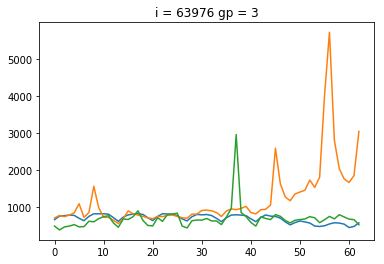

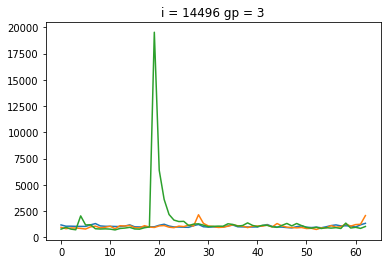

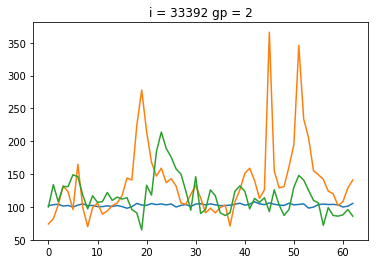

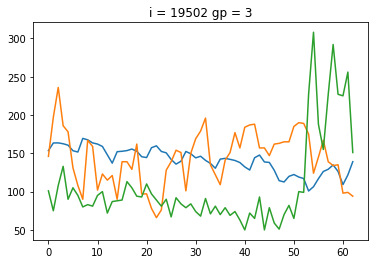

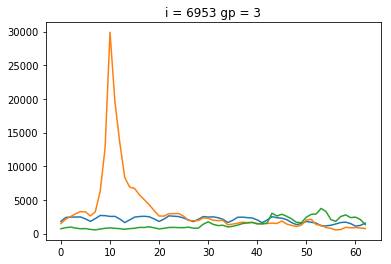

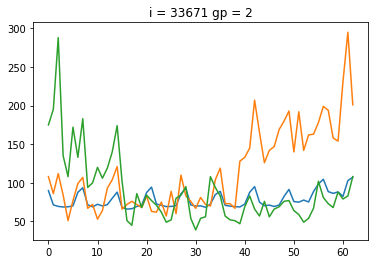

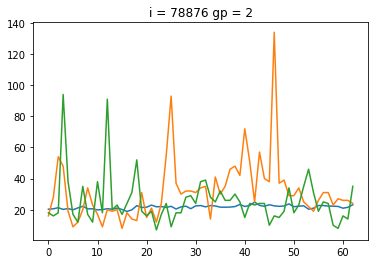

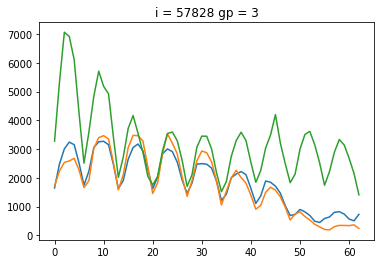

[69213, 72516, 63976, 14496, 33392, 19502, 6953, 33671, 78876, 57828]

In [172]:
examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

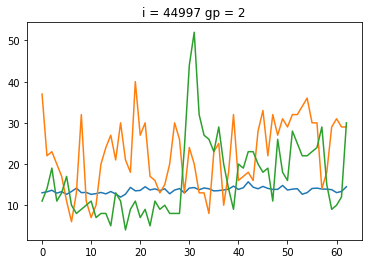

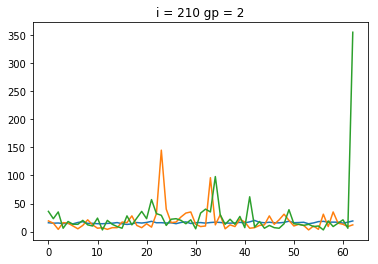

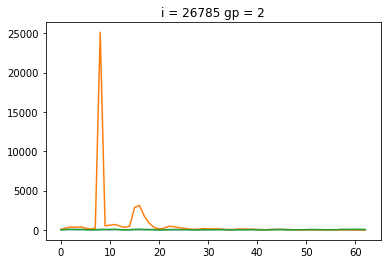

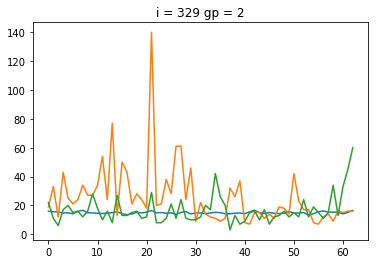

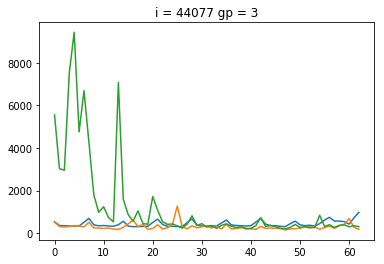

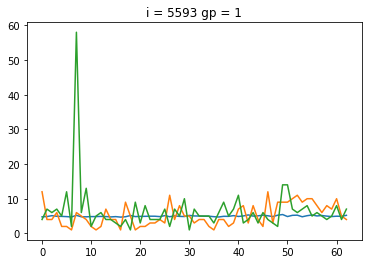

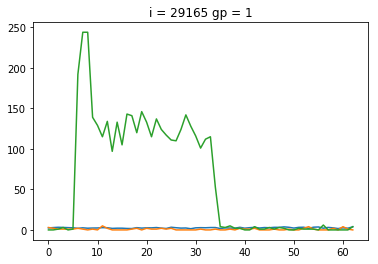

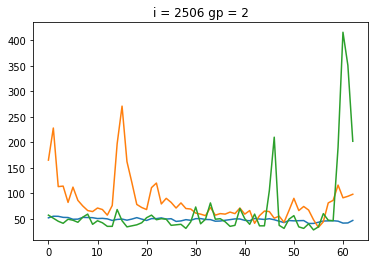

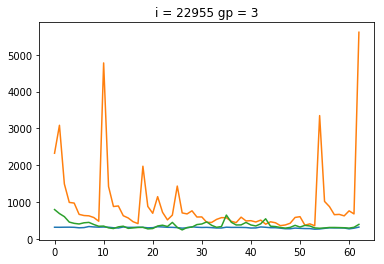

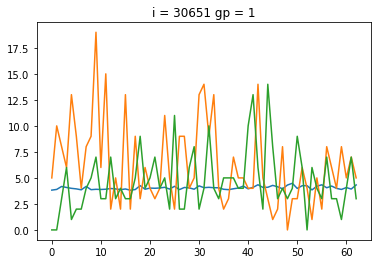

[44997, 210, 26785, 329, 44077, 5593, 29165, 2506, 22955, 30651]

In [173]:
examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

In [174]:
good_output_scale.min(), good_output_scale.max()

(0.0085879224631132522, 2.182821828651377)

In [175]:
bad_output_scale.min(), bad_output_scale.max()

(0.027026320401507382, 2.1612371446976013)

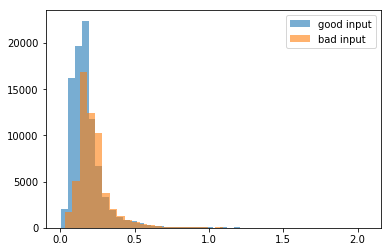

In [176]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

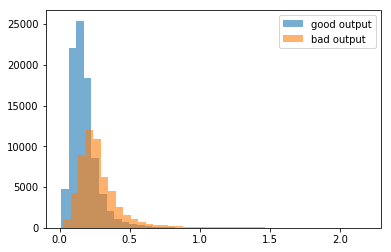

In [177]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

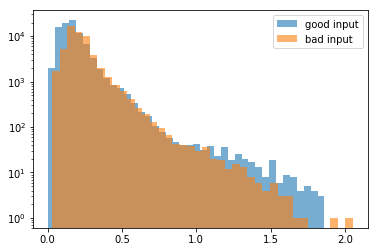

In [178]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

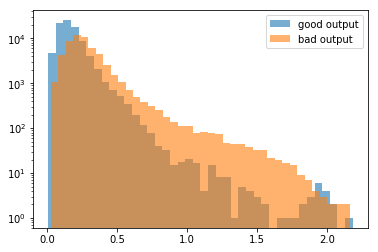

In [179]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

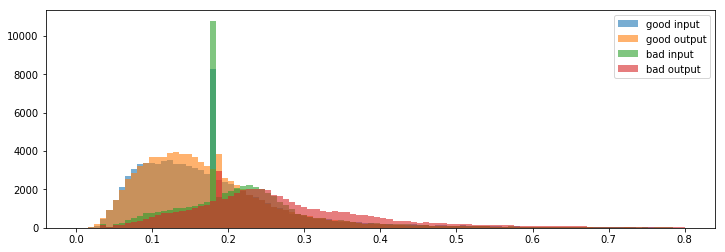

In [180]:
plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

In [181]:
np.mean(good_output_scale), np.mean(good_input_scale)

(0.17396701678733961, 0.18088279213085248)

In [182]:
np.mean(bad_output_scale), np.mean(bad_input_scale)

(0.29038064164303362, 0.2286977354861528)

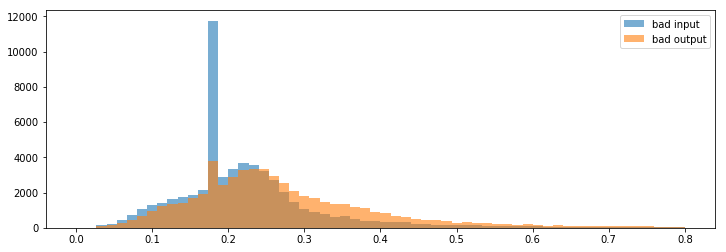

In [183]:
plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

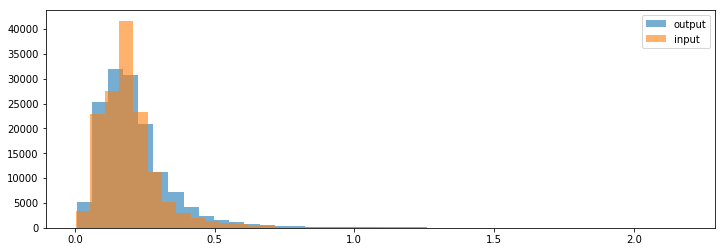

In [184]:
plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

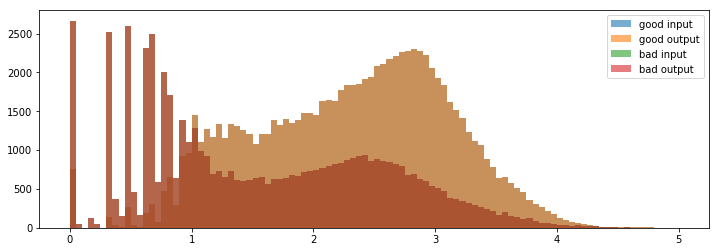

In [185]:
plt.figure(figsize=(12,4))
plt.hist(good_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

In [186]:
gc.collect()

287268

### stdev/median

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [187]:
Y_output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [188]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_fmc_ori, columns = Y_output_dates)  # using combined result
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]